# Zpráva k semestrální práci MI-PRC: Rychlá Fourierova transformace

**Marián Hlaváč** (hlavam30), marian.hlavac@fit.cvut.cz  
*Poslední aktualizace 25 Nov 2017*  
https://github.com/mmajko/FFT-cuda

## Zadání semestrální práce

Úkolem semestrální práce je implementovat sekvenční FFT algoritmus a převést jej na jednoduše paralelizovatelnou variantu. Následně výpočet tohoto algoritmu zrychlit pomocí programovacího modelu OpenACC a na závěr jej optimalizovat pro jednotky CUDA.

## Nástroje

K implementaci algoritmu byl využit jazyk C++, k aplikaci bylo napsáno několik podpůrných shell a Python skriptů a zpráva byla vypracována v Jupyter Notebooku.

## Algoritmus

Algoritmus byl implementován s využitím komplexních čísel, in-place, iterativně. Pro účely OpenACC pak byl upraven o formu vstupních a výstupních dat. Algoritmus pracuje s polem float čísel, obsahující sekvenčně za sebou reálné a imaginární části.

Na GPU je překopírována jednodušší varianta pole, shodná s počtem vzorků v instanci, tedy **n** (protože imaginární části jsou na začátku práce s algoritmem nulové), GPU si vytvoří výše zmíněnou strukturu pro komplexní čísla o velikosti **2n**. Po dokončení práce je z GPU překopírována pouze poloviční velikost tohoto pole, jelikož druhá část pole obsahuje neirelevantní výsledky (důsledek Nyquist–Shannon sampling theorem). Bylo by ještě více efektivnější překopírovat pouze reálné části z tohoto pole, ale to by pravděpodobně díky zvolené struktuře bylo složitější a nemuselo by to ušetřit prostředky.

### Vstupní data

Pro účely měření byl vygenerován balíček instancí, které sloužily jako vstupní data. Nacházejí se v repozitáři ve složce `data/` a jsou tříděny podle formy dat nacházejících se uvnitř dat do jednotlivých adresářů. V adresářích se pak nacházejí samotná data. Názvy souborů popisují další vlastnosti dat, jako je počet vzorků a vzorkovací frekvenci.

Počty vzorků pro měření byly zvoleny v rozsahu 128 - 65536.

### Výstupní data

Výstup algoritmu se uloží vedle datových souborů, s příponou `.out`. Tyto data pak lze hezky zobrazit pomocí krátkého Python skriptu, který je vykreslí ve formě grafů.

![](./fancyscreenshot.png)


Na standardní výstup se pak vypíší informace o průběhu výpočtu. Tyto informace jsou úzce přizpůsobeny pro účely zprávy, obsahují tak místy redundantní data. Informace jsou odděleny čárkou, aby pak byla jednoduše převoditelná do CSV formátu.

Pořadí informací je následující: 
 - složka s daty
 - počet vzorků
 - vzorkovací frekvence
 - počet OpenACC gangů / CUDA nastavení
 - doba trvání v mikrosekundách
 
Předposlední položka je proměnlivá v závislosti na podúkolu semestrální práce (OpenACC vs CUDA).

Řádky s hodnotou 0 ve sloupci **num_gangs** představují výpočet na CPU.


## OpenACC

OpenACC umožňuje pomocí `pragma` direktiv rychle obohatit algoritmus o paralelismus.

### Výsledky

Výstupem programu, jak bylo výše zmíněno, jsou CSV data obsahující informace o průběhu výpočtů:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Konfigurace vizualizace dat
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13.0, 7.0)
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 10

# Čtení dat z běhu programu
gpus = pd.read_csv("results/run-star.sh.o1912")
cpus = pd.read_csv("results/cpu")

data = pd.concat([gpus, cpus])
data

,folder,samples,sample_rate,num_gangs,elapsed_us
0,data/50Hz/,1024,44100,2,1309.00
1,data/50Hz/,1024,44100,4,843.00
2,data/50Hz/,1024,44100,8,568.00
3,data/50Hz/,1024,44100,16,417.75
4,data/50Hz/,1024,44100,32,346.50
...,...,...,...,...,...
25,data/500Hz+505Hz+12000Hz/,32768,44100,0,15517.20
26,data/500Hz+505Hz+12000Hz/,4096,44100,0,1539.50
27,data/500Hz+505Hz+12000Hz/,512,44100,0,155.00
28,data/500Hz+505Hz+12000Hz/,65536,44100,0,32967.20


### Závislost doby výpočtu na počtu vzorků

Průměr doby výpočtu společně na platformě CPU by měl naznačovat, jak obecně stoupá složitost výpočtu se vzrůstajícím počtem vzorků.

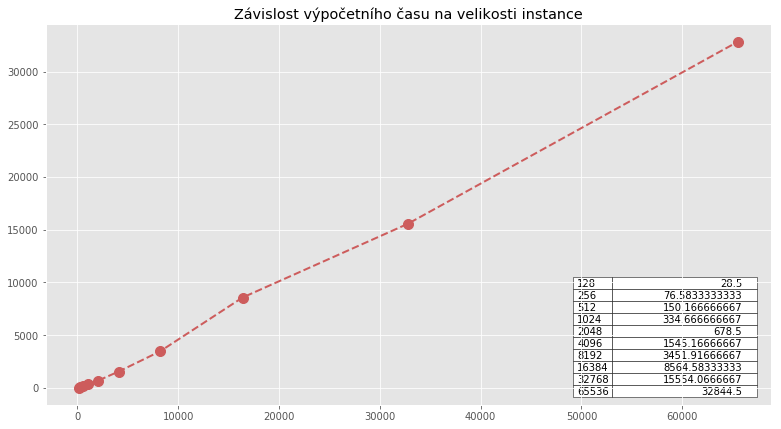

In [2]:
samplesvstime = data[data['num_gangs'] == 0].groupby('samples').mean()[['elapsed_us']]

plt.plot(samplesvstime, color='indianred', marker='o', markersize=10, ls='--', lw=2)
table = plt.table(cellText=samplesvstime.as_matrix(), loc='lower right', colWidths=[0.2], rowLabels=samplesvstime.index)
plt.title('Závislost výpočetního času na velikosti instance')
plt.show()

### Zrychlení díky paralelizaci

Níže lze vidět jakých rychlostí výpočtu se dosáhlo při různých úrovních paralelizace (nastavení `num_gangs`) průměrně pro všechny velikosti instancí.

*Jako dříve zmíněno, num_gangs=0 značí výpočet na CPU.*

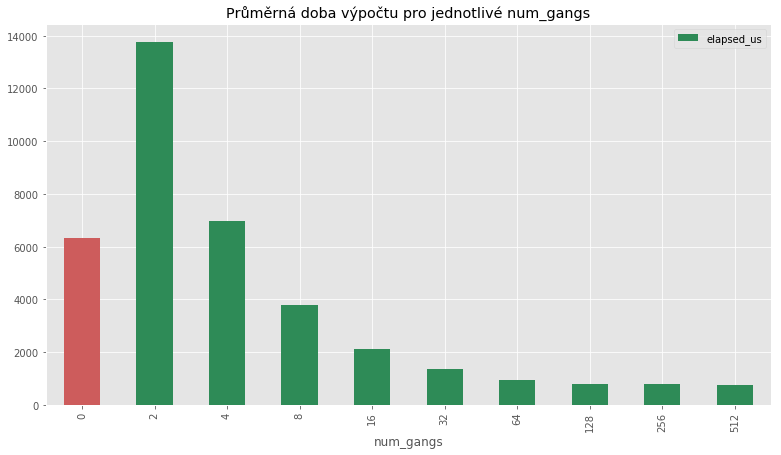

In [3]:
samplesvstime = data.groupby('num_gangs').mean()[['elapsed_us']]
ax = samplesvstime.plot(kind = 'bar', color='seagreen')
ax.set_title('Průměrná doba výpočtu pro jednotlivé num_gangs')
ax.patches[0].set_facecolor('indianred')

### Zrychlení díky paralelizaci relativně k velikosti instancí

K tomuto pokusu jsem vybral čtyři vzorky a pozoroval stejné vlastnosti jako na grafu výše, jen s tím rozdílem, že se nejedná o průměr všech velikostí instancí.

**Velikosti instancí jsou následující: 128, 1024, 8192 a 65536**

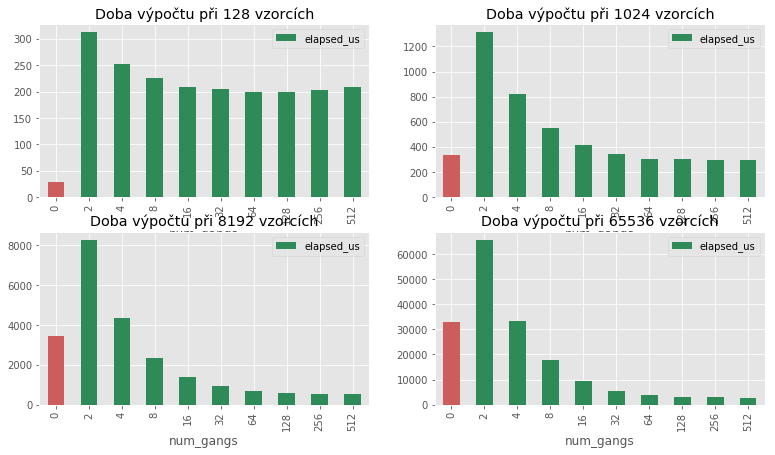

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for st in [[128, axes[0, 0]], [1024, axes[0, 1]], [8192, axes[1, 0]], [65536, axes[1, 1]]]:
    ax = data[data['samples'] == st[0]].groupby('num_gangs').mean()[['elapsed_us']].plot(kind='bar', color='seagreen', ax=st[1])
    ax.set_title('Doba výpočtu při {} vzorcích'.format(st[0]))
    ax.patches[0].set_facecolor('indianred')

### Závěr k implementaci OpenACC

Je přinejmenším záhadou, proč se **graf náročnosti výpočtu** se vzrůstajícím počtem prvků v instanci jeví jako lineární. Tady se v datech něco zřejmě nepovedlo, internetové zdroje tvrdí, že složitost FFT algoritmu je `O(n log n)`. Nemyslím si, že bych implementoval kouzelný algoritmus s lepší složitostí, než všechny ostatní. Vinu je pravděpodobně možné klást na nějakou cache, nebo jednodušeji na špatně spočítaná data o trvání výpočtů. Bohužel mě tlačí čas a tak k tomuto bodu odevzdání nemám prostor k nějaké investigativní aktivitě, abych zjistil, co se pokazilo.

**Graf zrychlení díky paralelizaci** dopadl mnohem lépe a podle očekávání. Režie kopírování dat na GPU je náročná a tak průměrně při num_gangs menším nebo rovno 4 nebylo dosaženo žádného zrychlení, ale právě naopak. Průměrně platilo, že s vyšším počtem num_gangs je ale výpočet rychlejší a efektivita paralelizace končí u num_gangs 256 a vyšší.

U menších instancí je tento fakt mnohem znatelnější, např. u instance o velikosti *128* lze pozorovat, že paralelizace vůbec nepomohla. Naopak u instance o velikosti *65536* lze pozorovat až `11,2x` zrychlení oproti výpočtu na CPU.


## CUDA

*...*

### Výsledky

...

### Závěr k implementaci CUDA

...


## Závěr

...

Zdrojové kódy programu lze najít na GitHubu. Odkaz je v hlavičce zprávy.